# Volatility Surface

This notebook explores and visualizes the concept of a volatility surface. 
The volatility surface is a three-dimensional plot where the x-axis is the time to maturity, the z-axis is the strike price, and the y-axis is the implied volatility.

## Imports

In [95]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import minimize_scalar 

## Data

In [96]:
ticker = 'AAPL'
apple_stock = yf.Ticker(ticker)

In [97]:
S = apple_stock.history(period='1d')['Close'][-1]
r = 0.04  # risk-free rate (Norwegian 1Y gorvernment bond)

In [98]:
expiration_dates = ['2023-12-29', '2024-01-05', '2024-01-12', '2024-01-19', \
    '2024-01-26', '2024-02-16', '2024-03-15', '2024-04-19', '2024-06-21', '2024-07-19', \
    '2024-09-20', '2024-12-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19', \
    '2026-01-16']

call_options = [apple_stock.option_chain(expiration_date).calls for expiration_date in expiration_dates]
strike_prices = [call_option['strike'] for call_option in call_options]
option_prices = [call_option['lastPrice'] for call_option in call_options]


In [99]:
flat_data = [(date, strike, price) for date, strikes, prices in zip(expiration_dates, strike_prices, option_prices)
             for strike, price in zip(strikes, prices)]
df = pd.DataFrame(flat_data, columns=['ExpirationDate', 'StrikePrice', 'OptionPrice'])
df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'])
df['T'] = (df['ExpirationDate'] - pd.to_datetime('today')).dt.days / 365.25
df

,ExpirationDate,StrikePrice,OptionPrice,T
0,2023-12-29,50.0,146.69,0.016427
1,2023-12-29,80.0,114.70,0.016427
2,2023-12-29,95.0,98.88,0.016427
3,2023-12-29,100.0,94.28,0.016427
4,2023-12-29,105.0,88.88,0.016427
...,...,...,...,...
752,2026-01-16,280.0,6.75,2.067077
753,2026-01-16,285.0,5.38,2.067077
754,2026-01-16,290.0,5.00,2.067077
755,2026-01-16,300.0,3.75,2.067077


## Calculate implied volatility

We calcuate the implied volatiltiy using the Black-Scholes option pricing model. Implied volatility is the volatility parameter in the Black-Scholes model that, when input into the model, results in an option price equal to the observed market price.

We use a numerical optimization approach to find the implied volatility that makes the calculated option price match the observed market price. 

In [100]:
N = norm.cdf

In [101]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * N(d1) - K * np.exp(-r*T)* N(d2)
    return call_price

In [102]:
def implied_vol(opt_value, S, K, T, r):
    
    def call_obj(sigma):
        return abs(black_scholes_call(S, K, T, r, sigma) - opt_value)
    
    res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
    return res.x

In [103]:
df['ImpliedVolatility'] = [implied_vol(op, S, K, T, r) for op, K, T in zip(df['OptionPrice'], df['StrikePrice'], df['T'])]
df

,ExpirationDate,StrikePrice,OptionPrice,T,ImpliedVolatility
0,2023-12-29,50.0,146.69,0.016427,5.999995
1,2023-12-29,80.0,114.70,0.016427,3.876049
2,2023-12-29,95.0,98.88,0.016427,2.211661
3,2023-12-29,100.0,94.28,0.016427,2.664274
4,2023-12-29,105.0,88.88,0.016427,1.902240
...,...,...,...,...,...
752,2026-01-16,280.0,6.75,2.067077,0.216913
753,2026-01-16,285.0,5.38,2.067077,0.207351
754,2026-01-16,290.0,5.00,2.067077,0.209465
755,2026-01-16,300.0,3.75,2.067077,0.204622


## Visualize volatility surface

In [104]:
surface = (
    df[['T', 'StrikePrice', 'ImpliedVolatility']]
    .pivot_table(values='ImpliedVolatility', index='StrikePrice', columns='T')
    .dropna()
)

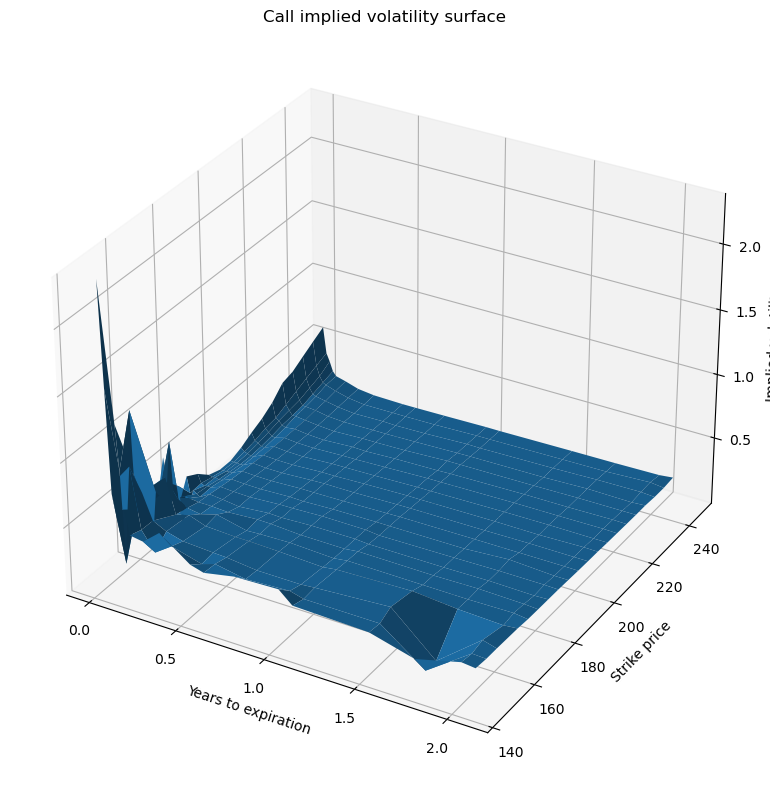

In [105]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x, y, z = surface.columns.values, surface.index.values, surface.values
X, Y = np.meshgrid(x, y)
ax.set_xlabel('Years to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Call implied volatility surface')
ax.plot_surface(X, Y, z)
plt.tight_layout()
plt.show()